# Final Project- Deep Learning for Image Analysis
## Hossein Moghimifam
## BreastPathQ Challenge

### importing needed libraries and general codes for the rest of the code

In [0]:
#importing the libraries used in the rest of the code
import os
import gzip
import shutil
import tarfile
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.models as models
import pandas as pd
import io

In [0]:
#checking what kind of system you are using
try:
    import google.colab
    from google.colab import drive
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

# if you are using colab put everything in 'My Drive/Colab Notebooks/Deep Learning/Final Project/'
if IN_COLAB:
  drive.mount('/content/gdrive')
  root_dir= '/content/gdrive/My Drive/Colab Notebooks/Deep Learning/Final Project/'
else:
  root_dir= ''

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [0]:
if IN_CADE:
    #setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
    define_gpu_to_use()

In [0]:
# the scoring function
def predprob(x, y, initial_lexsort=True):
    """
    Calculates the prediction probability. Adapted from scipy's implementation of Kendall's Tau

    Note: x should be the truth labels.

    Parameters
    ----------
    x, y : array_like
        Arrays of rankings, of the same shape. If arrays are not 1-D, they will
        be flattened to 1-D.
    initial_lexsort : bool, optional
        Whether to use lexsort or quicksort as the sorting method for the
        initial sort of the inputs. Default is lexsort (True), for which
        `predprob` is of complexity O(n log(n)). If False, the complexity is
        O(n^2), but with a smaller pre-factor (so quicksort may be faster for
        small arrays).
    Returns
    -------
    Prediction probability : float

    Notes
    -----
    The definition of prediction probability that is used is:
      p_k = (((P - Q) / (P + Q + T)) + 1)/2
    where P is the number of concordant pairs, Q the number of discordant
    pairs, and T the number of ties only in `y`.
    References
    ----------
    Smith W.D, Dutton R.C, Smith N.T. (1996) A measure of association for assessing prediction accuracy
    that is a generalization of non-parametric ROC area. Stat Med. Jun 15;15(11):1199-215
    """

    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if not x.size or not y.size:
        return (np.nan, np.nan)  # Return NaN if arrays are empty

    n = np.int64(len(x))
    temp = list(range(n))  # support structure used by mergesort
    # this closure recursively sorts sections of perm[] by comparing
    # elements of y[perm[]] using temp[] as support
    # returns the number of swaps required by an equivalent bubble sort

    def mergesort(offs, length):
        exchcnt = 0
        if length == 1:
            return 0
        if length == 2:
            if y[perm[offs]] <= y[perm[offs+1]]:
                return 0
            t = perm[offs]
            perm[offs] = perm[offs+1]
            perm[offs+1] = t
            return 1
        length0 = length // 2
        length1 = length - length0
        middle = offs + length0
        exchcnt += mergesort(offs, length0)
        exchcnt += mergesort(middle, length1)
        if y[perm[middle - 1]] < y[perm[middle]]:
            return exchcnt
        # merging
        i = j = k = 0
        while j < length0 or k < length1:
            if k >= length1 or (j < length0 and y[perm[offs + j]] <=
                                                y[perm[middle + k]]):
                temp[i] = perm[offs + j]
                d = i - j
                j += 1
            else:
                temp[i] = perm[middle + k]
                d = (offs + i) - (middle + k)
                k += 1
            if d > 0:
                exchcnt += d
            i += 1
        perm[offs:offs+length] = temp[0:length]
        return exchcnt

    # initial sort on values of x and, if tied, on values of y
    if initial_lexsort:
        # sort implemented as mergesort, worst case: O(n log(n))
        perm = np.lexsort((y, x))
    else:
        # sort implemented as quicksort, 30% faster but with worst case: O(n^2)
        perm = list(range(n))
        perm.sort(key=lambda a: (x[a], y[a]))

    # compute joint ties
    first = 0
    t = 0
    for i in range(1, n):
        if x[perm[first]] != x[perm[i]] or y[perm[first]] != y[perm[i]]:
            t += ((i - first) * (i - first - 1)) // 2
            first = i
    t += ((n - first) * (n - first - 1)) // 2

    # compute ties in x
    first = 0
    u = 0
    for i in range(1,n):
        if x[perm[first]] != x[perm[i]]:
            u += ((i - first) * (i - first - 1)) // 2
            first = i
    u += ((n - first) * (n - first - 1)) // 2

    # count exchanges
    exchanges = mergesort(0, n)
    # compute ties in y after mergesort with counting
    first = 0
    v = 0
    for i in range(1,n):
        if y[perm[first]] != y[perm[i]]:
            v += ((i - first) * (i - first - 1)) // 2
            first = i
    v += ((n - first) * (n - first - 1)) // 2

    tot = (n * (n - 1)) // 2
    if tot == u or tot == v:
        return (np.nan, np.nan)    # Special case for all ties in both ranks

    p_k = (((tot - (v + u - t)) - 2.0 * exchanges) / (tot - u) + 1)/2

    return p_k

In [0]:
#for segmentations tasks, the exact transformations that are applied to 
# the input image should be applied, down to the random number used, should
# also be applied to the ground truth and to the masks. We redefine a few of
# PyTorch classes 


#redefining composed transform so that it uses the _iterate_transforms function
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for transform in self.transforms:
            x = transform (x) 
        return x

#class to rerandomize the vertical flip transformation   
class RandomVerticalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform vertical flip using randomization provided by gen
class RandomVerticalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [2])
        return img

#class to rerandomize the horizontal flip transformation   
class RandomHorizontalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform horizontal flip using randomization provided by gen
class RandomHorizontalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [1])
        return img

In [0]:
# since the challenge website has been unavailable since April 25th,
#there is no way to check the score for the test set
#so part of the training set (15%) will be put aside as the training set

#input is a pandas dataframe
def get_split(df_to_split, split):
    np.random.seed(0)
    df_to_split=df_to_split.reindex(np.random.permutation(df_to_split.index))
    np.random.seed()
    if split == 'train':
        df_to_split = df_to_split[:int(len(df_to_split)*0.85)]
    elif split == 'test':
        df_to_split = df_to_split[int(len(df_to_split)*0.85):]
    return df_to_split

In [0]:
# defining normalization that has been used to train the pretrained models
# and its inverse
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [0]:
class Dataset(Dataset):

    def __init__(self, csv_file, root_dir=  root_dir+'breastpathq/datasets/', split= 'train', do_transform= False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if split != 'validation':
          self.image_names = get_split(pd.read_csv(root_dir + csv_file),split)
          split='train'
        else:
          self.image_names = pd.read_csv(root_dir + csv_file)
        self.root_dir = root_dir
        self.do_transform = do_transform
        self.split = split

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.split,
                                str(self.image_names.iloc[idx,0])+'_'+str(self.image_names.iloc[idx,1])+'.tif')
        image = TF.to_tensor(Image.open(img_name))
        y = self.image_names.iloc[idx, 2]
    

        if self.do_transform:
            v_gen = RandomVerticalFlipGenerator()
            h_gen = RandomHorizontalFlipGenerator()
            t = Compose([
                v_gen,
                RandomVerticalFlip(gen=v_gen),
                h_gen,
                RandomHorizontalFlip(gen=h_gen),
            ])
            image = t(image)

        return normalize(image), y

In [0]:
# use this function to 
# count how many parameters (learnable parameters, more specifically)
# there are in a pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
#use this function to score your models
def get_score_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        p_k = []
        for image, target in val_loader:
            image = image.cuda()
            out = model(image)
            target = target.float()
            p_k = np.append(p_k,predprob(target,out.cpu()))
            
#             logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()*mask.numpy()), axis = 0)
#             segmentations = np.concatenate((segmentations, segmentation.cpu().detach().numpy()*mask.numpy()), axis = 0)   
    #returns a list of scores, one for each of the labels
    return np.mean(p_k)

### Loading and visualizing the dataset

In [0]:
# defining training, validation, and test dataset
train_data= Dataset('train_labels.csv', do_transform= True)
val_data= Dataset('val_labels.csv', split= 'validation')
test_data= Dataset('train_labels.csv', do_transform= False, split= 'test')

In [0]:
# loading training, validation, and test dataset
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 20, num_workers = 0)
val_loader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = 37, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size = 36, num_workers = 0)

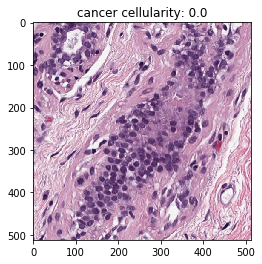

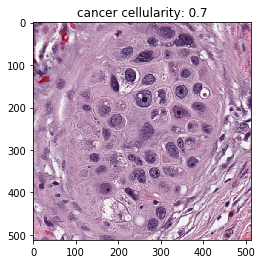

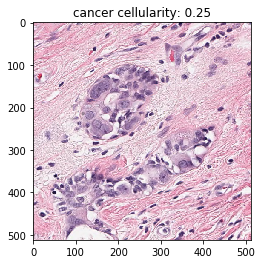

In [0]:
# visualizing some of the data to be sure that they are loaded correctly
i=0
for image, target in train_loader:
    i+=1
    if i<4:
        plt.imshow(inv_normalize(image[0,:,:,:]).permute([2,1,0]))
        plt.title('cancer cellularity: '+ str(target.cpu().numpy()[0]))
        plt.show()
    else:
        break

### training the model with different hyper-parameters

In [0]:
# defining the loss function
criterion = nn.MSELoss()

In [0]:
#hyper-parameters:
# (you may need to change)
learning_rates= [0.001,0.0001,0.00001,0.000001]
n_epochs = 20




train_losses= {}
val_accuracy= {}

for i in range(len(learning_rates)):
    max_score=0
    #base model: can use any of the pretrained models in pytorch (you may need to change)
    model = nn.Sequential(models.resnet18(pretrained= True),nn.Linear(in_features=1000, out_features=512, bias=True)
                      ,nn.Linear(in_features=512, out_features=128, bias=True)
                      ,nn.Linear(in_features=128, out_features=32, bias=True)
                      ,nn.Linear(in_features=32, out_features=1, bias=True))
    model = model.cuda()
    lr = learning_rates[i]
    # the training rate for the fully connected layers added to the base model is chosen 10 times the one of the  base model
    fc_lr= 10
    optimizer = torch.optim.Adam([
                {'params': model[0].parameters()},
                {'params': model[1].parameters(), 'lr': lr*fc_lr},
                {'params': model[2].parameters(), 'lr': lr*fc_lr},
                {'params': model[3].parameters(), 'lr': lr*fc_lr},
                {'params': model[4].parameters(), 'lr': lr*fc_lr}
            ], lr= lr)

    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    train_losses[lr] = []
    val_accuracy[lr] = []
    for epoch in range(n_epochs):

        # taking steps in scheduler
        #scheduler.step()

        losses=[]

        # toggling to training mode
        model.train()


        for images, targets in train_loader:

            # zero grading the optimizer
            optimizer.zero_grad()

            # transfering data to cuda unit
            images= images.cuda()

            targets= targets.view([-1,1]).float()

            targets= targets.cuda()
            #print(targets.shape)
            # finding output of the model and using mask on it
            out = model(images)


            # back propagation
            loss = criterion(out, targets)

            loss.backward()

            optimizer.step()

            losses.append(loss.item()) # 6) 7)

        print('Epoch ' + str(epoch)) # 6)
        print('loss1: ' + str(np.mean(losses))) # 6)
        train_losses[lr].append(np.mean(losses))
        score = get_score_model(model,val_loader)
        if score > max_score:
          max_score= score
          best_model= copy.deepcopy(model)
        print('Validation Set Score (P_k):')
        print(score)
        val_accuracy[lr].append(score)
    # it saves the bast trained model
    # (you may need to change) the name
    torch.save(best_model,root_dir+'best-resnet18-'+str(i))
        

Epoch 0
loss1: 101.34446652432283
Validation Set Score (P_k):
0.485993135993136
Epoch 1
loss1: 0.10902288751676678
Validation Set Score (P_k):
0.5977477477477479
Epoch 2
loss1: 0.08882020050659775
Validation Set Score (P_k):
0.8278957528957529
Epoch 3
loss1: 0.07749074677315851
Validation Set Score (P_k):
0.736111111111111
Epoch 4
loss1: 0.07345758449907104
Validation Set Score (P_k):
0.8030995280995281
Epoch 5
loss1: 0.06760840457864106
Validation Set Score (P_k):
0.7874731874731875
Epoch 6
loss1: 0.0631280576189359
Validation Set Score (P_k):
0.7483268983268984
Epoch 7
loss1: 0.0637387408564488
Validation Set Score (P_k):
0.8345452595452596
Epoch 8
loss1: 0.05359905579437812
Validation Set Score (P_k):
0.77987987987988
Epoch 9
loss1: 0.05106423075776547
Validation Set Score (P_k):
0.7990240240240241
Epoch 10
loss1: 0.04808659815850357
Validation Set Score (P_k):
0.8599099099099099
Epoch 11
loss1: 0.044144447908426324
Validation Set Score (P_k):
nan
Epoch 12
loss1: 0.03550182154091696

In [0]:
# saving the loss and validation set scores
import pickle

# Saving the objects:
# (you may need to change) the name
with open(root_dir+'modified_res18_last.pkl', 'wb') as f:
    pickle.dump([train_losses, val_accuracy], f)

### Import previously trained model for visualization and use

In [0]:
import pickle
# (you may need to change) the name
with open(root_dir+'modified_alexnet_model.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [train_losses, val_accuracy] = pickle.load(f)

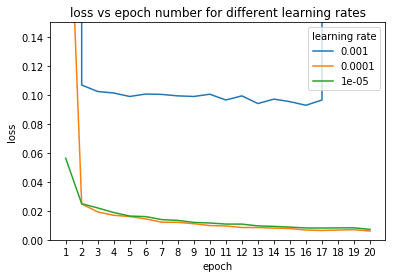

In [117]:
for key in train_losses.keys():
    plt.plot(list(range(1,len(train_losses[key])+1)),train_losses[key])
plt.legend(train_losses.keys(),loc=1,title='learning rate')
if len(train_losses[key])<25:
  plt.xticks(list(range(1,len(train_losses[key])+1)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,0.15)
plt.title('loss vs epoch number for different learning rates')
plt.show()

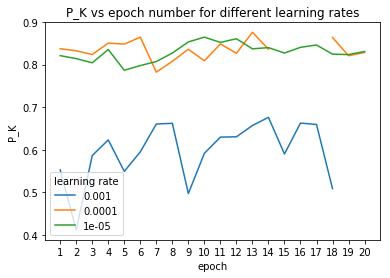

In [118]:
for key in val_accuracy.keys():
    plt.plot(list(range(1,len(val_accuracy[key])+1)),val_accuracy[key])
plt.legend(val_accuracy.keys(),title='learning rate')
if len(val_accuracy[key])<25:
  plt.xticks(list(range(1,len(val_accuracy[key])+1)))
plt.xlabel('epoch')
plt.ylabel('P_K')
plt.title('P_K vs epoch number for different learning rates')
plt.show()

### Training the best model for more number of epochs

In [0]:
#instantiate your model here:
n_epochs = 60

# (you may change this)
model = model=torch.load(root_dir+'best-resnet18-1')
model = model.cuda()
lr = 0.0001


optimizer = torch.optim.Adam([
                {'params': model[0].parameters()},
                {'params': model[1].parameters(), 'lr': lr*10},
                {'params': model[2].parameters(), 'lr': lr*10},
                {'params': model[3].parameters(), 'lr': lr*10},
                {'params': model[4].parameters(), 'lr': lr*10}
            ], lr= lr)

# Learning rate is reduced after plateauing to stabilize the end of training.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#train your model here:
score = 0
for epoch in range(n_epochs):

    # taking steps in scheduler
    scheduler.step()

    losses=[]

    # toggling to training mode
    model.train()


    for images, targets in train_loader:

        # zero grading the optimizer
        optimizer.zero_grad()

        # transfering data to cuda unit
        images= images.cuda()

        targets= targets.view([-1,1]).float()

        targets= targets.cuda()
        #print(targets.shape)
        # finding output of the model and using mask on it
        out = model(images)


        # back propagation
        loss = criterion(out, targets)

        loss.backward()

        optimizer.step()

        losses.append(loss.item()) # 6) 7)

    print('Epoch ' + str(epoch)) # 6)
    print('loss1: ' + str(np.mean(losses))) # 6)
  score = get_score_model(model,val_loader)
      if score > max_score:
        max_score= score
        best_model= copy.deepcopy(model)
# you may change this
torch.save(best_model,'bestmodelmodifiedresnet18')
        

Epoch 0
loss1: 0.044448481006127666
Epoch 1
loss1: 0.03372758297269515
Epoch 2
loss1: 0.029105822794678573
Epoch 3
loss1: 0.02780140119862689
Epoch 4
loss1: 0.024861206149129213
Epoch 5
loss1: 0.023052698588302185
Epoch 6
loss1: 0.020475250189157582
Epoch 7
loss1: 0.019696963866087224
Epoch 8
loss1: 0.016183067093685593
Epoch 9
loss1: 0.012395907403495079
Epoch 10
loss1: 0.010414927285794812
Epoch 11
loss1: 0.009006789849975081
Epoch 12
loss1: 0.007419807257983871
Epoch 13
loss1: 0.007100907147816501
Epoch 14
loss1: 0.006103550554994251
Epoch 15
loss1: 0.0057112698332070465
Epoch 16
loss1: 0.005310576312745195
Epoch 17
loss1: 0.004651217453049281
Epoch 18
loss1: 0.00469100921343893
Epoch 19
loss1: 0.004656140291862036
Epoch 20
loss1: 0.005231964079625082
Epoch 21
loss1: 0.00415366252725693
Epoch 22
loss1: 0.00383038047508116
Epoch 23
loss1: 0.0040259621115971795
Epoch 24
loss1: 0.0036538089098531942
Epoch 25
loss1: 0.0033051720032229773
Epoch 26
loss1: 0.0033717525336321883
Epoch 27
lo

In [130]:
get_score_model(best_model,test_loader)

0.8369043579966929